In [1]:
import os
import numpy as np
import librosa
import sounddevice as sd
from pydub import AudioSegment
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt
from pydub import AudioSegment
from pydub.generators import WhiteNoise
import librosa.effects
import soundfile as sf

In [2]:
# **Étape 1 : Fonction pour extraire les caractéristiques MFCC**
def extract_mfcc(audio_file, sr=16000, n_mfcc=13):
    y, sr = librosa.load(audio_file, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc.T, axis=0)

# **Étape 2 : Fonction pour charger les données**
def load_data_and_extract_features(folder, label):
    dataset = []
    for file_name in os.listdir(folder):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder, file_name)
            features = extract_mfcc(file_path)
            dataset.append((features, label))
    return dataset


In [ ]:
# **Étape 3 : Charger les données**
# Chemins des dossiers de données
allumer_folder = r".../allumer"
eteindre_folder = r".../eteindre"


In [4]:
# Charger les données
allumer_data = load_data_and_extract_features(allumer_folder, "allumer")
eteindre_data = load_data_and_extract_features(eteindre_folder, "eteindre")
# Combiner les données
dataset = allumer_data + eteindre_data
print(f"Nombre total de fichiers : {len(dataset)}")


Nombre total de fichiers : 348


In [5]:
print(len(eteindre_data))

174


In [6]:
# **Étape 4 : Préparation des données**
# Séparer X (caractéristiques) et y (étiquettes)
X = np.array([data[0] for data in dataset])  # Caractéristiques MFCC
y = np.array([data[1] for data in dataset])  # Étiquettes ("allumer", "eteindre", "inconnu")

# Encoder les étiquettes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normaliser les données
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)



In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialiser le modèle Random Forest
model = RandomForestClassifier(n_estimators=150, max_depth=6, random_state=42)

# Entraîner le modèle sur les données d'entraînement
model.fit(X_train, y_train)



RandomForestClassifier(max_depth=6, n_estimators=150, random_state=42)

In [8]:
# Prédictions sur l'ensemble d'entraînement
y_train_pred = model.predict(X_train)

# Précision sur l'ensemble d'entraînement
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Précision sur l'ensemble d'entraînement :", train_accuracy)

# Rapport de classification sur l'ensemble d'entraînement
print("Rapport de Classification sur l'ensemble d'entraînement :")
print(classification_report(y_train, y_train_pred, target_names=label_encoder.classes_))

Précision sur l'ensemble d'entraînement : 1.0
Rapport de Classification sur l'ensemble d'entraînement :
              precision    recall  f1-score   support

     allumer       1.00      1.00      1.00       139
    eteindre       1.00      1.00      1.00       139

    accuracy                           1.00       278
   macro avg       1.00      1.00      1.00       278
weighted avg       1.00      1.00      1.00       278



In [9]:
# Prédictions sur l'ensemble de test
y_test_pred = model.predict(X_test)

# Précision sur l'ensemble de test
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Précision sur l'ensemble de test :", test_accuracy)

# Rapport de classification sur l'ensemble de test
print("Rapport de Classification sur l'ensemble de test :")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


Précision sur l'ensemble de test : 0.9857142857142858
Rapport de Classification sur l'ensemble de test :
              precision    recall  f1-score   support

     allumer       0.97      1.00      0.99        35
    eteindre       1.00      0.97      0.99        35

    accuracy                           0.99        70
   macro avg       0.99      0.99      0.99        70
weighted avg       0.99      0.99      0.99        70



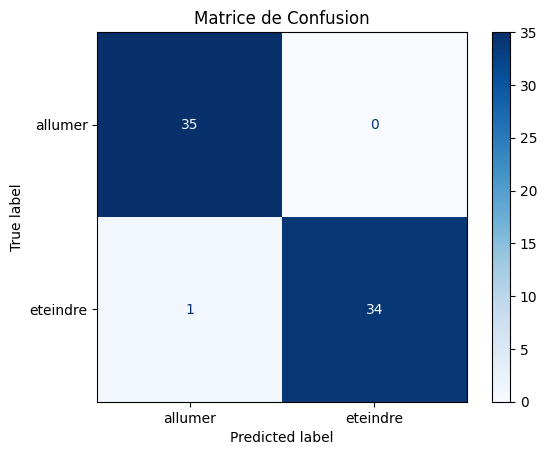

In [10]:
# Prédictions sur l'ensemble de test
y_test_pred = model.predict(X_test)

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

# Afficher avec les étiquettes originales
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title("Matrice de Confusion")
plt.show()

In [11]:
# **Étape 6 : Sauvegarder le modèle et les objets associés**
joblib.dump(model, "svm_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")



['label_encoder.pkl']

In [12]:
#  **Étape 7 : Fonction pour prédire un mot à partir d'un audio**
def predict_live_audio(model, scaler, label_encoder, sr=16000, duration=2):
    try:
        # Enregistrer un audio via le microphone
        print("Parlez maintenant...")
        audio = sd.rec(int(duration * sr), samplerate=sr, channels=1)
        sd.wait()
        print("Enregistrement terminé.")
        
        # Extraire les MFCC
        mfcc = librosa.feature.mfcc(y=audio.flatten(), sr=sr, n_mfcc=13)
        features = np.mean(mfcc.T, axis=0).reshape(1, -1)
        features = scaler.transform(features)
        
        # Faire la prédiction
        probabilities = model.predict_proba(features)
        predicted_label = model.predict(features)
        predicted_word = label_encoder.inverse_transform(predicted_label)[0]
        
        # Vérifier si le mot est connu ou inconnu
        if probabilities[0].max() < 0.80:  # Seuil de confiance
            print("Mot détecté : Inconnu")
        else:
            print(f"Mot détecté : {predicted_word}")
    except Exception as e:
        print(f"Erreur lors de la reconnaissance : {e}")


In [13]:
# **Étape 8 : Tester la reconnaissance en temps réel**
model = joblib.load("svm_model.pkl")
scaler = joblib.load("scaler.pkl")
label_encoder = joblib.load("label_encoder.pkl")

In [32]:
predict_live_audio(model, scaler, label_encoder)

Parlez maintenant...
Enregistrement terminé.
Mot détecté : allumer


In [15]:
predict_live_audio(model, scaler, label_encoder)

Parlez maintenant...
Enregistrement terminé.
Mot détecté : Inconnu
